In [1]:
import sys
import os
import yaml
from itertools import product
from collections import defaultdict
from tqdm.auto import tqdm

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy import interpolate, optimize
from sklearn.linear_model import LinearRegression

import pandas as pd
from sympy import parse_expr, lambdify, latex, Symbol

from pymongo import MongoClient
import pymongo

from seml.database import get_collection
from seml.evaluation import parse_jsonpickle

In [2]:
plt.rcParams['text.usetex'] = True

In [3]:
def parameters(width, depth, dimension):
    """Computes number of parameters in MLP with widths `width`,
    depth `depth`, and input dimension `dimension`. Assumes the neurons
    have biases.
    """
    return (dimension * width + width) + (depth - 2)*(width * width + width) + (width + 1)

In [4]:
equations = pd.read_csv('../../equations.csv')

In [5]:
simplex_collection = get_collection('highd-simplex-0')
tanh_collection = get_collection('feynman-network-5')
relu_collection = get_collection('feynman-network-8')

In [6]:
eqns = ["I.30.5", "I.8.14", "I.44.4", "II.6.15a"]

In [7]:
optimal_dimension = {
    'I.10.7': 2,
    'I.30.5': 2,
    'I.8.14': 2, # 1 previously
    'I.39.22': 2,
    'I.44.4': 2,
    'I.12.11': 2, # 1 previously
    'II.6.15a': 2,
    'I.11.19': 2
}

0it [00:00, ?it/s]

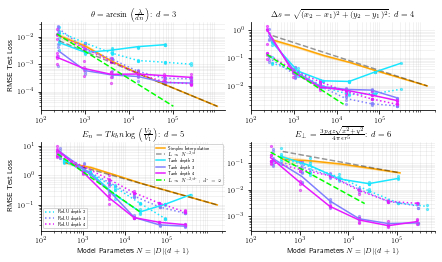

In [8]:
plt.figure(figsize=(6.0, 3.5))

# for rending equations properly, set manually
symbol_names = {
    Symbol('Ef'): 'E_f',
    Symbol('E_den'): 'E_{\text{den}}',
    Symbol('lambd'): '\lambda',
    Symbol('kb'): 'k_b'
}


for j, eqn in tqdm(enumerate(eqns)):
    ax = plt.subplot(2, 2, j+1)
    
    relu_lines = []
    other_lines = []
    
    fields = ['config', 'info']
    query = {
        'status': 'COMPLETED',
        'config.eqn': eqn
    }
    results = list(simplex_collection.find(query, fields))
    dimension = results[0]['info']['dimension']
    sequence = [(r['config']['TRAIN_POINTS'] * (dimension + 1), r['info']['test']) for r in results]
    xs = sorted(list(set([s[0] for s in sequence])))
    means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
    stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])
    min_simplex_mean = min(means)
    
    line, = plt.plot(xs, means, label='Simplex Interpolation', color='orange', alpha=1.0)
    other_lines.append(line)
    plt.fill_between(xs, means-stds, means+stds, color='orange', alpha=0.2)

    x, y = xs[-1], means[-1]
    C = y / np.power(x, -2 / dimension)
    ys = C * np.power(xs, -2 / dimension)
    line, = plt.plot(xs, ys, '--', color='black', alpha=0.4, label="$L \propto N^{-2/d}$")
    other_lines.append(line)
    
    colors = plt.cm.cool(np.linspace(0.1, 0.9, 3))
    for i, depth in enumerate([2, 3, 4]):
        fields = ['config', 'info', 'results']
        query = {
            'status': 'COMPLETED',
            'config.eqn': eqn,
            'config.lr': 0.001,
            'config.depth': depth,
            'config.activation': 'Tanh'
        }
        results = list(tanh_collection.find(query, fields))
        if results:
            dimension = results[0]['info']['dimension']
            sequence = []
            for r in results:
                width, depth = r['config']['width'], r['config']['depth']
                p = parameters(width, depth, dimension)
                sequence.append((p, r['info']['test_at_min_train']))
            xs = sorted(list(set([s[0] for s in sequence])))
            plt.scatter(*zip(*sequence), color=colors[i], s=5, alpha=0.6)
            means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
            medians = np.array([np.median([s[1] for s in sequence if s[0] == x]) for x in xs])
            mins = np.array([np.min([s[1] for s in sequence if s[0] == x]) for x in xs])
            stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])
            line, = plt.plot(xs, medians, label=f'Tanh depth {depth}', color=colors[i], alpha=1.0, linewidth=1.5)
            other_lines.append(line)
#             xs = sorted(list(set([s[0] for s in sequence])))
#             means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
#             stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])
#             plt.plot(xs, means, label=f'ReLU depth {depth}', color=colors[i], alpha=1.0, linewidth=1.0)
#             plt.fill_between(xs, means-stds, means+stds, color=colors[i], alpha=0.2)


        fields = ['config', 'info', 'results']
        query = {
            'status': 'COMPLETED',
            'config.eqn': eqn,
            'config.lr': 0.001,
            'config.depth': depth,
            'config.activation': 'ReLU'
        }
        results = list(relu_collection.find(query, fields))
        if results:
            dimension = results[0]['info']['dimension']
            sequence = []
            for r in results:
                width, depth = r['config']['width'], r['config']['depth']
                p = parameters(width, depth, dimension)
                sequence.append((p, r['info']['test_at_min_train']))
            xs = sorted(list(set([s[0] for s in sequence])))
            plt.scatter(*zip(*sequence), color=colors[i], s=5, alpha=0.6)
            means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
            medians = np.array([np.median([s[1] for s in sequence if s[0] == x]) for x in xs])
            mins = np.array([np.min([s[1] for s in sequence if s[0] == x]) for x in xs])
            stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])
            line, = plt.plot(xs, medians, label=f'ReLU depth {depth}', color=colors[i], alpha=1.0, linewidth=1.5, linestyle='dotted')
            relu_lines.append(line)

    if eqn in optimal_dimension:
        eff_dim = optimal_dimension[eqn]
        x, y = xs[0], means[0]
        if eqn == 'II.6.15a':
            y = 2.0*y
        C = y / np.power(x, -2 / eff_dim)
        end_x = np.power(min(means[-1], min_simplex_mean) / C, -eff_dim / 2)
        xs = np.linspace(x, end_x, 100)
        ys = C * np.power(xs, -2 / eff_dim)
        line, = plt.plot(xs, ys, '--', color='lime', alpha=1.0, label=r"$L \propto N^{-2/{d^*}}; \ d^* = 2$")
        other_lines.append(line)
    plt.yscale('log')
    plt.xscale('log')
    plt.xticks([100, 1000, 10000, 100000], fontsize=7)
    plt.yticks(fontsize=7)
    row = equations[equations['Equation'] == eqn]
    eqn_formula = row['Formula'].item()
    eqn_variables = [row[f'v{i}_name'].item() for i in range(1, dimension+1)]
    output=row['Output'].item()
#     print(output)
    if output == 'Ef':
        output = 'E_\perp'
    if output == 'theta':
        output = '\\theta'
    if output == 'E_den':
        output = 'u'
    if j >= 2:
        plt.xlabel(r"Model Parameters $N = |D|(d+1)$", fontsize=7)
    if j % 2 == 0:
        plt.ylabel("RMSE Test Loss", fontsize=7)
    if dimension == 1:
        full_formula = f"{eqn_formula}"
        plt.title(f"${output}={latex(parse_expr(full_formula), symbol_names=symbol_names)}$: $d = {dimension}$", fontsize=8)
    else:
        if eqn == 'I.8.14':
                plt.title(r"$\Delta s=\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$:" +  f" $d = {dimension}$", fontsize=8)
        else:
            full_formula = f"{eqn_formula}"
            plt.title(f"${output}={latex(parse_expr(full_formula), symbol_names=symbol_names)}$: $d = {dimension}$", fontsize=8)

    plt.tick_params(axis='x', which='major')
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.grid(True, which="both", linestyle='-', linewidth=0.5, alpha=0.3)
#     if dimension == 1:
#         full_formula = f"{eqn_formula}"
#         plt.title(f"${latex(parse_expr(full_formula), symbol_names=symbol_names)}$: {dimension}-dim", fontsize=8)
#     else:
# #         full_formula = f"{row['Output'].item()}(x) = {eqn_formula}"
#         full_formula = f"{eqn_formula}"
#         plt.title(f"${latex(parse_expr(full_formula), symbol_names=symbol_names)}$: {dimension}-dim", fontsize=8)
    if j == 2:
        first_legend = ax.legend(handles=other_lines, prop={'size': 4.5}, loc='upper right')
        ax.add_artist(first_legend)
        ax.legend(handles=relu_lines, prop={'size': 4.5}, loc='lower left')



plt.tight_layout(pad=0.2)

plt.savefig("../final-figures/highdim-tanh-annotated-half-normalized.pdf")